# 交互式前景提取使用GrabCut算法

### 目标

在本章中，
- 我们将看到GrabCut算法来提取图像中的前景
- 我们将为此创建一个交互式应用程序。

### 理论
GrabCut算法由英国微软研究院的Carsten Rother，Vladimir Kolmogorov和Andrew Blake设计。在他们的论文“GrabCut”中：使用迭代图割的交互式前景提取。需要用最少的用户交互进行前景提取的算法，结果是GrabCut。

从用户角度来看，它是如何工作的？最初，用户在前景区域周围绘制一个矩形（前景区域应完全位于矩形内部）。然后，算法会对其进行迭代分割，以获得最佳结果。做完了但在某些情况下，分割可能不会很好，例如，可能已将某些前景区域标记为背景，反之亦然。在这种情况下，需要用户进行精修。只需在图像错误分割区域上画些笔画。笔画基本上说 “嘿，该区域应该是前景，你将其标记为背景，在下一次迭代中对其进行校正”或与背景相反。然后在下一次迭代中，你将获得更好的结果。

参见下图。第一名球员和橄榄球被封闭在一个蓝色矩形中。然后用白色笔划（表示前景）和黑色笔划（表示背景）进行最后的修饰。而且我们得到了不错的结果。

![](data/grabcut_output1.jpg)

那么背景发生了什么呢？
- 用户输入矩形。此矩形外部的所有内容都将作为背景（这是在矩形应包含所有对象之前提到的原因）。矩形内的所有内容都是未知的。同样，任何指定前景和背景的用户输入都被视为硬标签，这意味着它们在此过程中不会更改。
- 计算机根据我们提供的数据进行初始标记。它标记前景和背景像素（或对其进行硬标记），现在使用高斯混合模型(GMM)对前景和背景进行建模。
- 根据我们提供的数据，GMM可以学习并创建新的像素分布。也就是说，未知像素根据颜色统计上与其他硬标记像素的关系而被标记为可能的前景或可能的背景（就像聚类一样）。
- 根据此像素分布构建图形。图中的节点为像素。添加了另外两个节点，即“源”节点和“接收器”节点。每个前景像素都连接到源节点，每个背景像素都连接到接收器节点。
- 通过像素是前景/背景的概率来定义将像素连接到源节点/末端节点的边缘的权重。像素之间的权重由边缘信息或像素相似度定义。如果像素颜色差异很大，则它们之间的边缘将变低。
- 然后使用mincut算法对图进行分割。它将图切成具有最小成本函数的两个分离的源节点和宿节点。成本函数是被切割边缘的所有权重的总和。剪切后，连接到“源”节点的所有像素都变为前景，而连接到“接收器”节点的像素都变为背景。
- 继续该过程，直到分类收敛为止。

如下图所示（图片提供：http://www.cs.ru.ac.za/research/g02m1682/） 

![](data/grabcut_scheme.jpg)

### 示例

现在我们使用OpenCV进行抓取算法。OpenCV为此具有功能**cv.grabCut**()，我们将首先看到其参数：
- *img* - 输入图像
- *mask* - 这是一个掩码图像，在其中我们指定哪些区域是背景，前景或可能的背景/前景等。这是通过以下标志完成的：**cv.GC_BGD**,**cv.GC_FGD**, **cv.GC_PR_BGD**,**cv.GC_PR_FGD**，或直接将`0,1,2,3`传递给图像。
- *rect* - 它是矩形的坐标，其中包括前景对象，格式为`(x,y,w,h)`
- *bdgModel, fgdModel* - 这些是算法内部使用的数组。你只需创建两个大小为`(1,65)`的`np.float64`类型零数组。
- *iterCount* - 算法应运行的迭代次数。
- *model* - 应该是**cv.GC_INIT_WITH_RECT**或**cv.GC_INIT_WITH_MASK**或两者结合，决定我们要绘制矩形还是最终的修饰笔触。
  
首先让我们看看矩形模式。我们加载图像，创建类似的mask图像。
我们创建*fgdModel*和*bgdModel*。我们给出矩形参数。一切都是直截了当的。让算法运行5次迭代。模式应为**cv.GC_INIT_WITH_RECT**, 因为我们使用的是矩形。
然后运行grabcut。修改mask图像。在新的mask图像中，像素将被标记有四个标记，分别表示上面指定的背景/前景。因此，我们修改mask，使所有0像素和2像素都置为0（即背景），而所有1像素和3像素均置为1（即前景像素）。现在，我们的最终mask已经准备就绪。只需将其与输入图像相乘即可得到分割的图像。

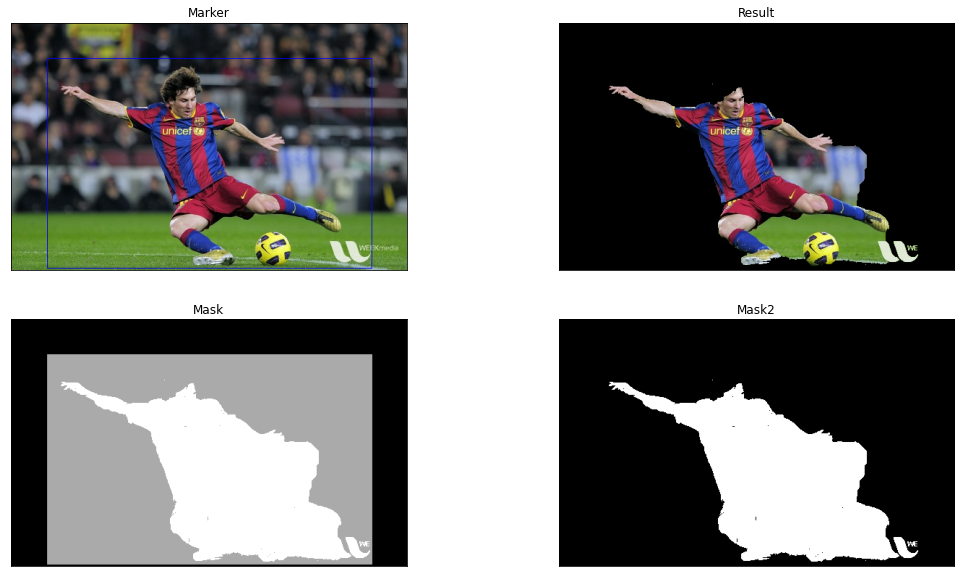

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

org = cv.imread('data/messi5.jpg')
img = org.copy()

mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (50,50,450,290)
marker = org.copy()
cv.rectangle(marker, rect, (255, 0, 0), 1)

cv.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

plt.figure(figsize=(18,10))

plt.subplot(221),plt.imshow(cv.cvtColor(marker,cv.COLOR_BGR2RGB))
plt.title('Marker'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
plt.title('Result'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(mask, 'gray')
plt.title('Mask'), plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(mask2, 'gray')
plt.title('Mask2'), plt.xticks([]), plt.yticks([])
# plt.colorbar()

plt.show()

糟糕，梅西的头发不见了。谁会喜欢没有头发的梅西？我们需要把它找回来。因此，我们将使用1像素（确保前景）进行精细修饰。同时，一些不需要的地面也出现在图片里。我们需要删除它们。在那里，我们给出了一些0像素的修饰（确保背景）。因此，如现在所说，我们在以前的情况下修改生成的mask。

*我实际上所做的是，我在paint应用程序中打开了输入图像，并在图像中添加了另一层。使用画笔中的画笔工具，我在新图层上用白色标记了错过的前景（头发，鞋子，球等），而用白色标记了不需要的背景（例如logo，地面等）。然后用灰色填充剩余的背景。然后将该mask图像加载到OpenCV中，编辑我们在新添加的mask图像中具有相应值的原始mask图像。*

检查以下代码： 

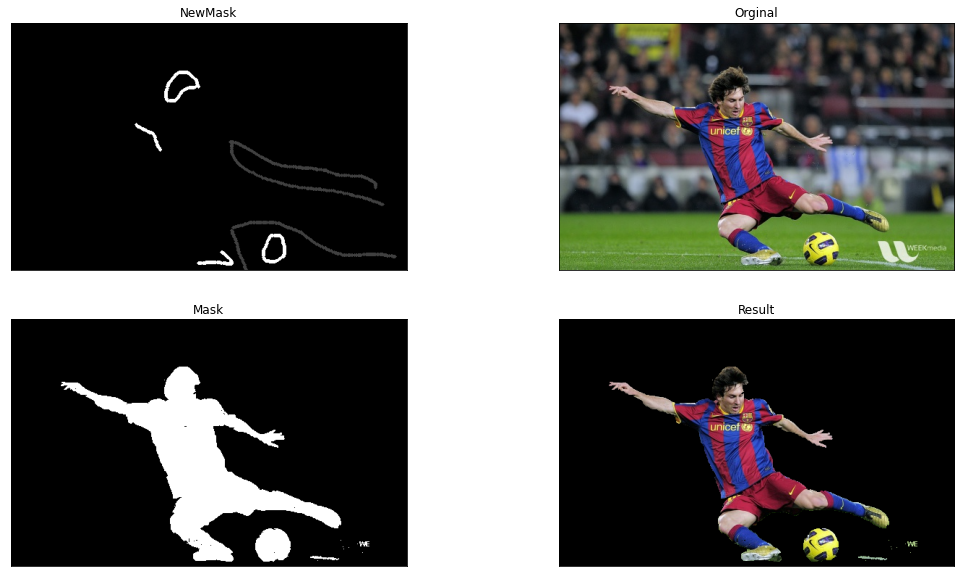

In [2]:
# newmask是我手动标记过的mask图像
newmask = cv.imread('output/newmask.png',0)

# 标记为白色（确保前景）的地方，更改mask = 1
# 标记为黑色（确保背景）的地方，更改mask = 0
mask3 = mask.copy()

mask3[newmask == 64] = 0
mask3[newmask == 255] = 1

mask4, bgdModel, fgdModel = cv.grabCut(img,mask3,None,bgdModel,fgdModel,5,cv.GC_INIT_WITH_MASK)
mask4 = np.where((mask3==2)|(mask3==0),0,1).astype('uint8')

img = org*mask4[:,:,np.newaxis]

plt.figure(figsize=(18,10))

plt.subplot(221),plt.imshow(newmask, 'gray')
plt.title('NewMask'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(cv.cvtColor(org,cv.COLOR_BGR2RGB))
plt.title('Orginal'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(mask4, 'gray')
plt.title('Mask'), plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
plt.title('Result'), plt.xticks([]), plt.yticks([])
# plt.colorbar()

plt.show()

就是这样了。在这里，你无需直接在rect模式下初始化，而可以直接进入mask模式。只需用2像素或3像素（可能的背景/前景）标记mask图像中的矩形区域。然后像在第二个示例中一样，将我们的sure_foreground标记为1像素。然后直接在mask模式下应用grabCut功能。

### 附加资源

下面是进行标注的工具代码。

In [3]:
import numpy as np
import cv2 as cv

drawing = False # 如果按下鼠标，则为真
mode = True # 如果为真，绘制前景
fg = []
bg = []

# 鼠标回调函数
def draw_circle(event,x,y,flags,param):
    global drawing,mode
    if event == cv.EVENT_LBUTTONDOWN:
        drawing = True
    elif event == cv.EVENT_MOUSEMOVE:
        if drawing == True:
            if mode == 0:
                cv.circle(image,(x,y),3,(255,255,255),-1)
                fg.append((x,y))
            else:
                cv.circle(image,(x,y),3,(64,64,64),-1)
                bg.append((x,y))
    elif event == cv.EVENT_LBUTTONUP:
        drawing = False
        if mode == 0:
            cv.circle(image,(x,y),3,(255,255,255),-1)
            fg.append((x,y))
        else:
            cv.circle(image,(x,y),3,(64,64,64),-1)
            bg.append((x,y))

def modeChanged(x):
    pass

# 创建一个黑色的图像，一个窗口，并绑定到窗口的功能
image = cv.imread('data/messi5.jpg')
cv.namedWindow('image')
cv.setMouseCallback('image',draw_circle)

switch = '0:f, 1:b'
cv.createTrackbar(switch, 'image',0,1,modeChanged)

while(1):
    cv.imshow('image',image)
    if cv.waitKey(5) & 0xFF == 27:
        break

    mode = cv.getTrackbarPos(switch,'image')

h, w = image.shape[:2]
image = np.zeros((h,w), np.uint8)

for pt in fg:
    cv.circle(image,pt,2,255,-1)

for pt in bg:
    cv.circle(image,pt,2,64,-1)

if len(fg) > 0 or len(bg) > 0:
    cv.imwrite('output/newmask.png', image)
    print('newmask.png updated.')

cv.destroyAllWindows()

### 练习

1. OpenCV示例包含一个示例catchcut.py这是一个使用grabcut的交互式工具。检查。另请观看有关如何使用它的youtube视频。
2. 在这里，你可以通过绘制矩形和使用鼠标笔触使其成为交互式示例，创建轨迹栏以调整笔触宽度等。